# Petfinder.my Adoption Prediction
How cute is that doggy in the shelter?

## Competition Description:

Millions of stray animals suffer on the streets or are euthanized in shelters every day around the world. If homes can be found for them, many precious lives can be saved — and more happy families created.

PetFinder.my has been Malaysia’s leading animal welfare platform since 2008, with a database of more than 150,000 animals. PetFinder collaborates closely with animal lovers, media, corporations, and global organizations to improve animal welfare.

Animal adoption rates are strongly correlated to the metadata associated with their online profiles, such as descriptive text and photo characteristics. As one example, PetFinder is currently experimenting with a simple AI tool called the Cuteness Meter, which ranks how cute a pet is based on qualities present in their photos.

In this competition you will be developing algorithms to predict the adoptability of pets - specifically, how quickly is a pet adopted? If successful, they will be adapted into AI tools that will guide shelters and rescuers around the world on improving their pet profiles' appeal, reducing animal suffering and euthanization.

Top participants may be invited to collaborate on implementing their solutions into AI tools for assessing and improving pet adoption performance, which will benefit global animal welfare.

## Objective:
you will predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder. Sometimes a profile represents a group of pets. In this case, the speed of adoption is determined by the speed at which all of the pets are adopted. The data included text, tabular, and image data. See below for details. 

#### AdoptionSpeed

Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way: 
<br>0 - Pet was adopted on the same day as it was listed. 
<br>1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 
<br>2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 
<br>3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
<br>4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).



__File descriptions:__
<br>train.csv - Tabular/text data for the training set
<br>test.csv - Tabular/text data for the test set
<br>sample_submission.csv - A sample submission file in the correct format
<br>breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
<br>color_labels.csv - Contains ColorName for each ColorID
<br>state_labels.csv - Contains StateName for each StateID


Data Fields

- PetID - Unique hash ID of pet profile
- AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
- Type - Type of animal (1 = Dog, 2 = Cat)
- Name - Name of pet (Empty if not named)
- Age - Age of pet when listed, in months
- Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
- Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
- Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
- Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
- Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
- Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
- MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
- Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- Quantity - Number of pets represented in profile
- Fee - Adoption fee (0 = Free)
- State - State location in Malaysia (Refer to StateLabels dictionary)
- RescuerID - Unique hash ID of rescuer
- VideoAmt - Total uploaded videos for this pet
- PhotoAmt - Total uploaded photos for this pet
- Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

### Evaluation:

scored based on the quadratic weighted kappa, which measures the agreement between two ratings. This metric typically varies from 0 (random agreement between raters) to 1 (complete agreement between raters). In the event that there is less agreement between the raters than expected by chance, the metric may go below 0. The quadratic weighted kappa is calculated between the scores which are expected/known and the predicted scores.

Results have 5 possible ratings, 0,1,2,3,4.  The quadratic weighted kappa is calculated as follows. First, an N x N histogram matrix O is constructed, such that Oi,j corresponds to the number of adoption records that have a rating of i (actual) and received a predicted rating j. An N-by-N matrix of weights, w, is calculated based on the difference between actual and predicted rating scores:

$$\begin{equation*}
w_{ij} = \frac{(i-j)^2}{(N-1)^2}
\end{equation*} $$


An N-by-N histogram matrix of expected ratings, E, is calculated, assuming that there is no correlation between rating scores.  This is calculated as the outer product between the actual rating's histogram vector of ratings and the predicted rating's histogram vector of ratings, normalized such that E and O have the same sum.

From these three matrices, the quadratic weighted kappa is calculated as: 

$$\begin{equation*}
\kappa = 1 - \frac{\sum_(w_{ij} O_{ij})}{\sum_(w_{ij} E_{ij})}
\end{equation*} $$



In [1]:
import pandas as pd
import numpy as np

import os, json

In [2]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [3]:
#load codes tables

breed = pd.read_csv('../data/breed_labels.csv')
color = pd.read_csv('../data/color_labels.csv')
state = pd.read_csv('../data/state_labels.csv')


In [4]:
train = pd.read_csv('../data/train.csv')

In [5]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

## Features to add from train dataset
- number of colors
- pure bred or mixed breed
- Description length

In [6]:
color_cols = ['Color1', 'Color2', 'Color3']

In [7]:
def set_breed(row):
    """ this function sets the Mixed Breed Indicator for the pet
        a dog is set as Mixed Breed if either Breed1 or Breed2 = 370
        or both Breed1 and Breed2 is set to some value greater than 0.
        A cat is set as Mixed Breed if either Breed1 or Breed2 = 266
        or both Breed1 and Breed2 is set to some value greater than 0.
    """
    if (row['Type'] == 'Dog'): 
        if (((row['Breed1'] == 370) | (row['Breed2'] == 370)) |
            ((row['Breed1'] > 0) & (row['Breed2'] > 0))):
            return 'Mixed'
        else:
            return 'Pure'
    else: # if 'Cat'
        if (((row['Breed1'] == 266) | (row['Breed2'] == 266)) |
            ((row['Breed1'] > 0) & (row['Breed2'] > 0))):
            return 'Mixed'
        else:
            return 'Pure'

In [8]:
def get_desc_len(row):
    """ return length of Pet's profile Description"""
    return len(row['Description'])

In [9]:
def get_name_len(row):
    """ return length of Pet's Name"""
    return len(row['Name'])

In [10]:
def get_color_count(row):
    """ return the number of colors of the pet"""
    color_count = 0
    
    for color in color_cols:
        if row[color] > 0:
            color_count +=1
            
    return color_count

In [11]:
def get_age_cat(row):
    """ return the age category for dogs and cats """
    if row['Type'] == 'Dog':
        if (row['Age'] >= 0) & (row['Age'] < 24):
            return 'dog_0_23'
        elif (row['Age'] >= 24) & (row['Age'] < 72):
            return 'dog_24_71'
        elif (row['Age'] >= 72) & (row['Age'] < 120):
            return 'dog_72_119'
        elif row['Age'] >= 120:
            return 'dog_120_above'
    else:
        if (row['Age'] >= 0) & (row['Age'] < 2):
            return 'cat_0_1'
        elif (row['Age'] >= 2) & (row['Age'] < 6):
            return 'cat_2_5'
        elif (row['Age'] >= 6) & (row['Age'] < 12):
            return 'cat_6_11'
        elif row['Age'] >= 12:
            return 'cat_12_above'        

In [12]:
def process_sentiment(filetype):
    """ This function processes the description sentiment file and creates a sentiment score dataframe.
        the filetype (train or test) will be a required parameter"""
    
    path_to_json = '../data/{}_sentiment/'.format(filetype)
    json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
    json_dict = {'pet_id':[],'magnitude':[], 'score':[]}

    for index, js in enumerate(json_files):
     
        with open(os.path.join(path_to_json, js)) as json_file:
            json_text = json.load(json_file)
            json_dict['pet_id'].append(js.split('.')[0])
            json_dict['magnitude'].append(json_text['documentSentiment']['magnitude'])
            json_dict['score'].append(json_text['documentSentiment']['score'])
            
    sentiDF = pd.DataFrame(json_dict)
    return sentiDF

In [13]:
def add_features(df, filetype):
    """ This function adds new features to our dataFrame as part of pre-processing
        of train and test data.  The parameter filetype will either be (train or test)"""
    
    dfAll = df.copy()

    #Handle Missing Values
    dfAll['Name'] = dfAll.Name.fillna('').values
    dfAll['Description'] = dfAll.Name.fillna('').values
    
    
    #Add Features
    dfAll['Name_Ind'] = dfAll['Name'].apply(lambda x: 'withName' if len(x) > 0 else 'noName')
    dfAll['Name_Len'] = dfAll.apply(lambda x: get_name_len(x), 1)
    dfAll['Type'] = dfAll['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
    dfAll['Breed_Ind'] = dfAll.apply(lambda x: set_breed(x), 1)
    dfAll['Desc_Len'] = dfAll.apply(lambda x: get_desc_len(x), 1)
    dfAll['Color_count'] = dfAll.apply(lambda x: get_color_count(x), 1)
    dfAll['health'] = dfAll['Vaccinated'].astype(str) + '_' + dfAll['Dewormed'].astype(str) + '_' + dfAll['Sterilized'].astype(str) + '_' + dfAll['Health'].astype(str)
    dfAll['age_cat'] = dfAll.apply(lambda x:get_age_cat(x), 1) 

    #Get descriptions for the different numeric categorical features
    colors_dict = {k: v for k, v in zip(color['ColorID'], color['ColorName'])}
    dfAll['Color1_name'] = dfAll['Color1'].apply(lambda x: '_'.join(colors_dict[x].split()) if x in colors_dict else 'Unknown')
    dfAll['Color2_name'] = dfAll['Color2'].apply(lambda x: '_'.join(colors_dict[x]) if x in colors_dict else '-')
    dfAll['Color3_name'] = dfAll['Color3'].apply(lambda x: '_'.join(colors_dict[x]) if x in colors_dict else '-')
    
    breeds_dict = {k: v for k, v in zip(breed['BreedID'], breed['BreedName'])}
    dfAll['Breed1_name'] = dfAll['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
    dfAll['Breed2_name'] = dfAll['Breed2'].apply(lambda x: '_'.join(breeds_dict[x]) if x in breeds_dict else '-')
    
    
    #After all the new columns have been added to the dataframe.  Join dfAll with desc_df to populate
    #the dataframe with the description sentiment score
    desc_df = process_sentiment(filetype)
    desc_df.rename(index=str, columns={'pet_id': 'PetID'}, inplace=True)
    dfAll = dfAll.merge(desc_df, on=['PetID'], how='left')
    dfAll.fillna(0, inplace=True)
    
    dfAll['sentiment'] = dfAll.apply(lambda x: x['magnitude'] * x['score'], 1)
    
    return dfAll

In [14]:
#desc_df = pd.read_pickle('../data/out/desc_score.pkl')

In [15]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [16]:
dfAll = add_features(train, 'train')

In [17]:
dfAll.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Name_Ind', 'Name_Len', 'Breed_Ind', 'Desc_Len', 'Color_count',
       'health', 'age_cat', 'Color1_name', 'Color2_name', 'Color3_name',
       'Breed1_name', 'Breed2_name', 'magnitude', 'score', 'sentiment'],
      dtype='object')

In [18]:
dfAll.isnull().sum()

Type             0
Name             0
Age              0
Breed1           0
Breed2           0
Gender           0
Color1           0
Color2           0
Color3           0
MaturitySize     0
FurLength        0
Vaccinated       0
Dewormed         0
Sterilized       0
Health           0
Quantity         0
Fee              0
State            0
RescuerID        0
VideoAmt         0
Description      0
PetID            0
PhotoAmt         0
AdoptionSpeed    0
Name_Ind         0
Name_Len         0
Breed_Ind        0
Desc_Len         0
Color_count      0
health           0
age_cat          0
Color1_name      0
Color2_name      0
Color3_name      0
Breed1_name      0
Breed2_name      0
magnitude        0
score            0
sentiment        0
dtype: int64

### Exploratory Data Analysis

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

NLP description from [Google Cloud](https://cloud.google.com/natural-language/docs/basics)


documentSentiment contains the overall sentiment of the document, which consists of the following fields:
- __score__: of the sentiment ranges between -1.0 (negative) and 1.0 (positive) and corresponds to the overall emotional leaning of the text.
- __magnitude__: indicates the overall strength of emotion (both positive and negative) within the given text, between 0.0 and +inf. Unlike score, magnitude is not normalized; each expression of emotion within the text (both positive and negative) contributes to the text's magnitude (so longer text blocks may have greater magnitudes).

In [20]:
dfAll.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Name_Ind', 'Name_Len', 'Breed_Ind', 'Desc_Len', 'Color_count',
       'health', 'age_cat', 'Color1_name', 'Color2_name', 'Color3_name',
       'Breed1_name', 'Breed2_name', 'magnitude', 'score', 'sentiment'],
      dtype='object')

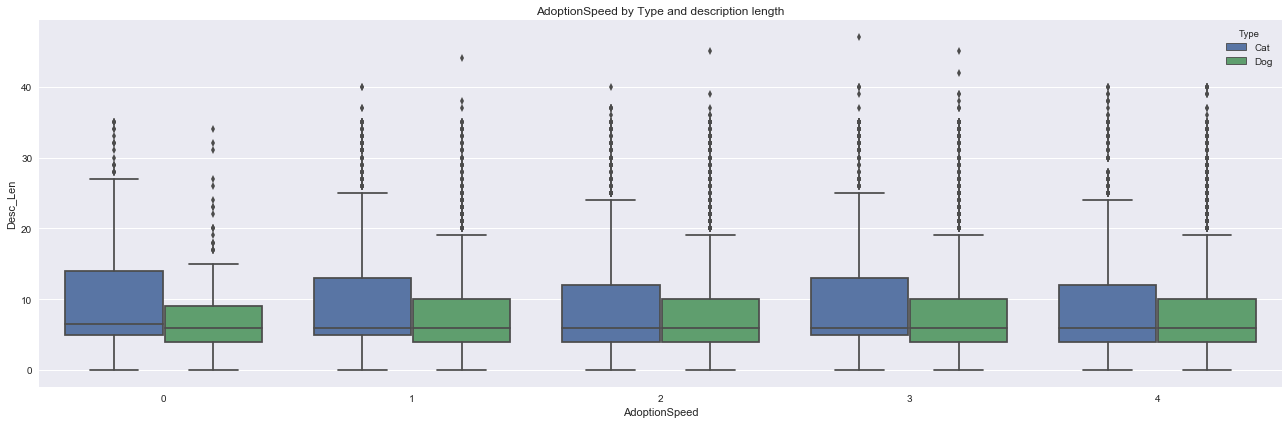

In [21]:
fig = plt.figure(figsize=(18, 6));
sns.boxplot(x="AdoptionSpeed", y="Desc_Len", hue="Type", data=dfAll);
plt.title('AdoptionSpeed by Type and description length');
fig.tight_layout()
plt.savefig('../images/DescLenx_AdoptSpeed.png')

In [22]:
dfAll[dfAll.Desc_Len > 20][['AdoptionSpeed', 'Description','Quantity','score','sentiment']][-50:]

,AdoptionSpeed,Description,Quantity,score,sentiment
14452,4,Black Dog - Lucky Named By Rescurer,1,0.1,0.17
14467,3,12 Cute & Chubby Soldiers,1,0.0,0.00
14472,1,Kitten Swap With RC Kitten 10kg,1,0.0,0.00
14478,2,Hamtaro. Goofy And Maru,3,0.0,0.00
14479,3,Little Angel (Special Case),1,0.4,3.16
14488,1,RETRIEVER - FOUND SS14 SUBANG JAYA,1,0.1,0.23
14489,1,Wait For The Real Owner To Name It,4,0.2,0.76
14493,2,"Tabby Webby, Muffin & Snow White",3,0.1,0.29
14500,3,3 Months Old Kittens For Free Adopt,3,0.3,0.18
14506,4,Bushy Calico - Found In Kinrara,1,0.1,0.24


In [23]:
dfAll[(dfAll['score'] > 0.32) & (dfAll['AdoptionSpeed'] == 0)]['Description'][:10]

75               Coco
170            Sunset
260           Wei Wei
740         Dalmation
1011    Molly (momol)
1015          Shimbha
1050          Mun Mun
1057                 
1183    Angel & Tesco
1295            Puppy
Name: Description, dtype: object

In [24]:
dfAll.groupby(['Type','AdoptionSpeed'])[['sentiment','score']].median()

sentiment  score
Type AdoptionSpeed                  
Cat  0                   0.30    0.2
     1                   0.40    0.2
     2                   0.42    0.2
     3                   0.42    0.2
     4                   0.36    0.3
Dog  0                   0.32    0.3
     1                   0.32    0.2
     2                   0.36    0.2
     3                   0.40    0.2
     4                   0.42    0.3

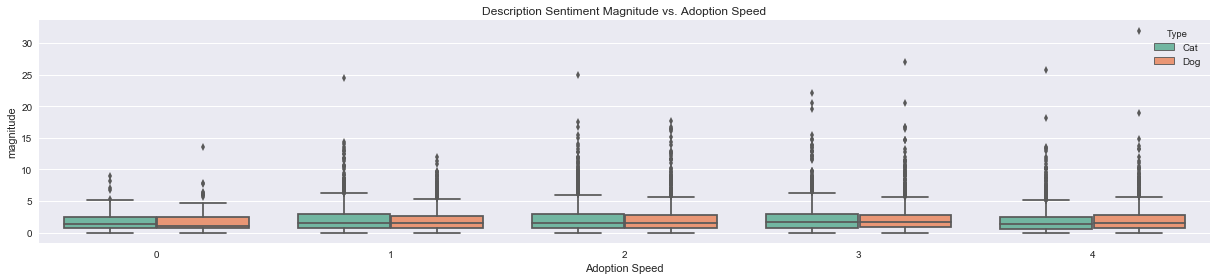

In [25]:
fig = plt.figure(figsize=(17,4))
sns.boxplot(y='magnitude', x='AdoptionSpeed', hue='Type', data=dfAll, palette='Set2')
plt.xlabel('Adoption Speed')
plt.ylabel('magnitude')
plt.title('Description Sentiment Magnitude vs. Adoption Speed')
#plt.show()
fig.tight_layout()
plt.savefig('../images/Desc_magnitude_x_AdoptSpeed.png')

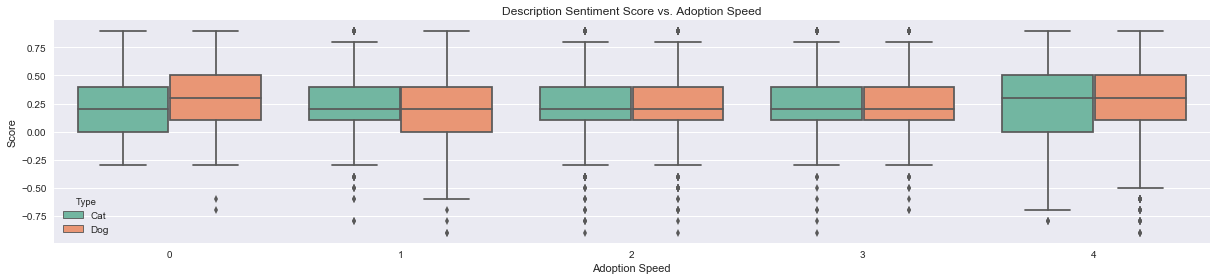

In [26]:
fig = plt.figure(figsize=(17,4))
sns.boxplot(y='score', x='AdoptionSpeed', hue='Type', data=dfAll, palette='Set2')
plt.xlabel('Adoption Speed')
plt.ylabel('Score')
plt.title('Description Sentiment Score vs. Adoption Speed')
#plt.show()
fig.tight_layout()
plt.savefig('../images/Desc_score_x_AdoptSpeed.png')

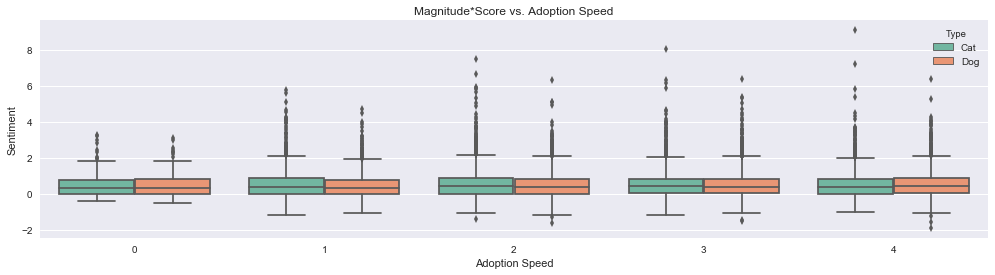

In [27]:
fig = plt.figure(figsize=(17,4))
sns.boxplot(y='sentiment', x='AdoptionSpeed', hue='Type', data=dfAll, palette='Set2')
plt.xlabel('Adoption Speed')
plt.ylabel('Sentiment')
plt.title('Magnitude*Score vs. Adoption Speed')
plt.savefig('../images/Sentiment_x_AdoptSpeed.png')

### Distribution of Adoption Speed by Pet Type

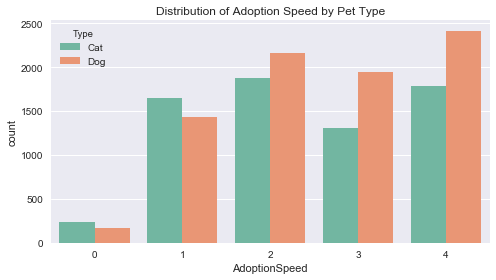

In [28]:
fig = plt.figure(figsize=(7,4))
sns.countplot(x='AdoptionSpeed',data=dfAll, hue='Type', palette='Set2')
plt.title('Distribution of Adoption Speed by Pet Type')
fig.tight_layout()
plt.savefig('../images/Dist_adoptspeed_x_pet.png')

In [29]:
tot_Dogs = dfAll[dfAll.Type == 'Dog']['Type'].count()
tot_Dogs

8132

In [30]:
dfAll.groupby(['Type', 'AdoptionSpeed'])

### Distribution of pets (Cats vs Dogs)

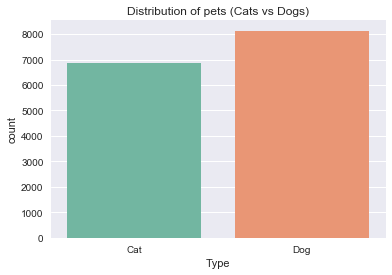

In [31]:
sns.countplot(x='Type',data=dfAll, palette='Set2')
plt.title('Distribution of pets (Cats vs Dogs)')
plt.savefig('../images/Dist_petType.png')

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


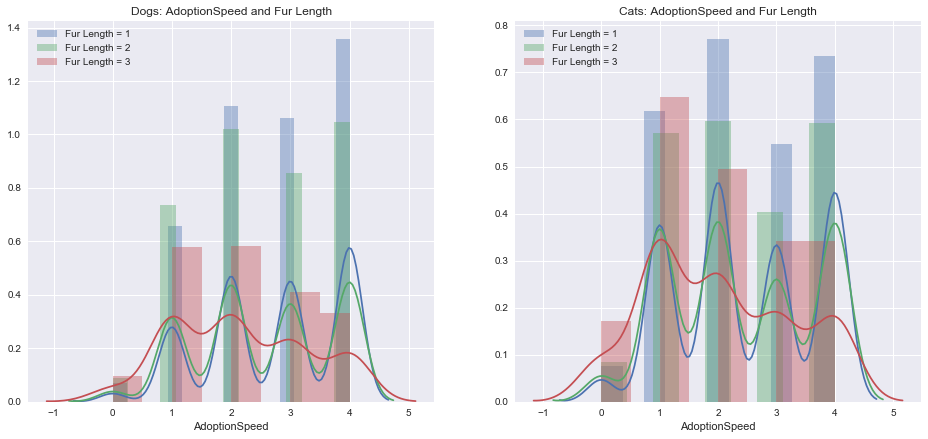

In [150]:
fig = plt.figure(figsize=(16,7))
plt.subplot(1,2,1)

plt.title('Dogs: AdoptionSpeed and Fur Length')
for furlen in range(1,4):
    sns.distplot(dfAll[(dfAll.Type=='Dog')&(dfAll.FurLength == furlen)]
                 ['AdoptionSpeed'].dropna(), hist=True, rug=False, label="Fur Length = {}".format(furlen))
plt.legend()    
plt.subplot(1,2,2)    
plt.title('Cats: AdoptionSpeed and Fur Length')
for furlen in range(1,4):
    sns.distplot(dfAll[(dfAll.Type=='Cat')&(dfAll.FurLength == furlen)]
                 ['AdoptionSpeed'].dropna(), hist=True, rug=False, label="Fur Length = {}".format(furlen))
plt.legend()
fig.savefig('../images/FurLen_x_AdoptSpeed.png', bbox_inches='tight')

In [116]:
dfAll['age_cat'].unique()

array(['cat_2_5', 'cat_0_1', 'dog_0_23', 'cat_12_above', 'dog_72_119',
       'cat_6_11', 'dog_24_71', 'dog_120_above'], dtype=object)

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


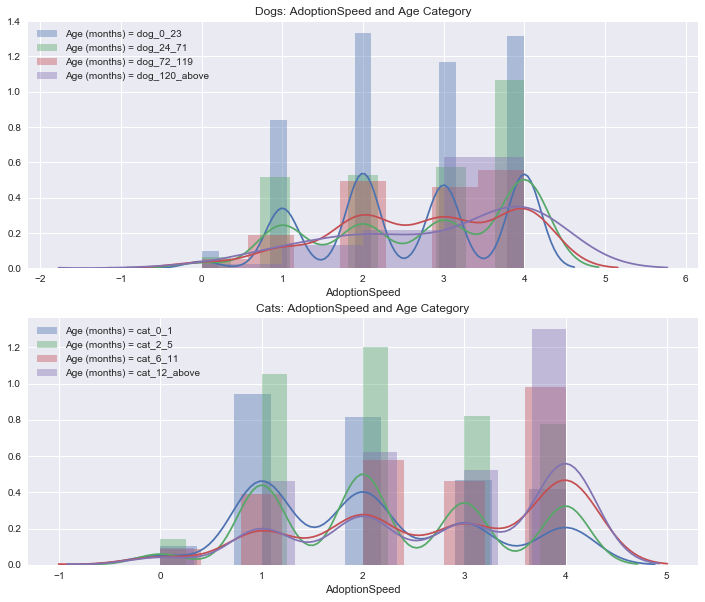

In [149]:
cat_age = ['cat_0_1', 'cat_2_5','cat_6_11', 'cat_12_above']
dog_age = ['dog_0_23','dog_24_71', 'dog_72_119','dog_120_above']
fig = plt.figure(figsize=(12,10))
plt.subplot(2,1,1)

plt.title('Dogs: AdoptionSpeed and Age Category')
for age in dog_age:
    sns.distplot(dfAll[(dfAll.Type=='Dog')&(dfAll.age_cat == age)]
                 ['AdoptionSpeed'].dropna(), hist=True, rug=False, label="Age (months) = {}".format(age))
plt.legend()    
plt.subplot(2,1,2)    
plt.title('Cats: AdoptionSpeed and Age Category')

for age in cat_age:
    sns.distplot(dfAll[(dfAll.Type=='Cat')&(dfAll.age_cat == age)]
                 ['AdoptionSpeed'].dropna(), hist=True, rug=False, label="Age (months) = {}".format(age))

plt.legend()   
fig.savefig('../images/AgeCat_x_AdoptSpeed.png', bbox_inches='tight')


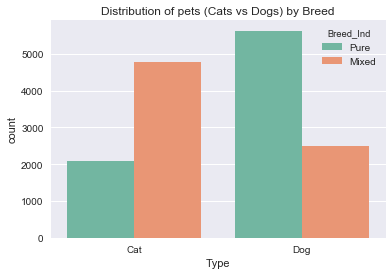

In [34]:
sns.countplot(x="Type", hue="Breed_Ind", data=dfAll, palette='Set2')
plt.title('Distribution of pets (Cats vs Dogs) by Breed')
plt.savefig('../images/Dist_byBreed.png', bbox_inches='tight')

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


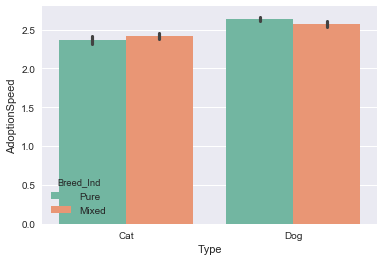

In [35]:
sns.barplot(x='Type', y='AdoptionSpeed', hue='Breed_Ind', data=dfAll, palette='Set2')
plt.xlabel('Type')
plt.ylabel('AdoptionSpeed')
plt.show()

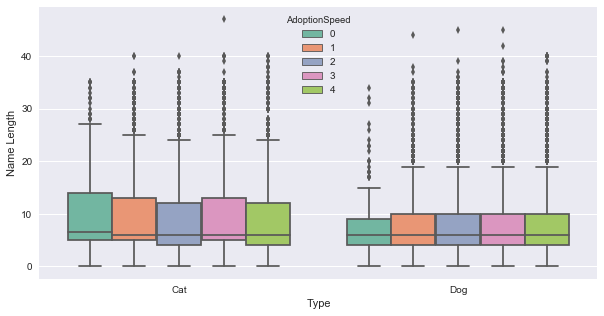

In [36]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(x='Type', y='Name_Len', hue='AdoptionSpeed', data=dfAll, palette='Set2')
plt.xlabel('Type')
plt.ylabel('Name Length')
plt.savefig('../images/NameLength.png', bbox_inches='tight')

In [37]:
dfAll.groupby(['AdoptionSpeed','Type'])['Name_Len'].mean()

AdoptionSpeed  Type
0              Cat     10.362500
               Dog      7.758824
1              Cat      9.240483
               Dog      8.136585
2              Cat      8.930593
               Dog      8.414510
3              Cat      9.451908
               Dog      8.498717
4              Cat      8.862030
               Dog      8.361640
Name: Name_Len, dtype: float64

In [38]:
dfAll[dfAll.Name_Len == 0].groupby(['AdoptionSpeed','Type'])['PetID'].count()

AdoptionSpeed  Type
0              Cat      11
               Dog      15
1              Cat     147
               Dog     124
2              Cat     159
               Dog     153
3              Cat     115
               Dog     101
4              Cat     176
               Dog     256
Name: PetID, dtype: int64

It looks like for pet names, cats with longer names are more popular - Faster Adoption speed, which is the opposite for dogs.  Dogs with shorter names have faster adoption speed.

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


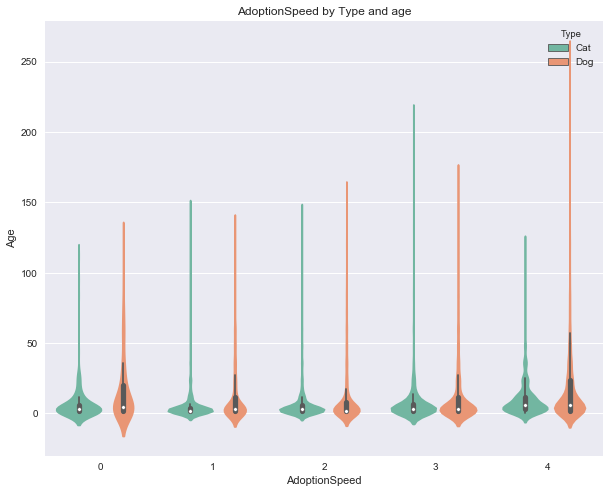

In [39]:
plt.figure(figsize=(10, 8));
sns.violinplot(x="AdoptionSpeed", y="Age", hue="Type", data=dfAll, palette='Set2');
plt.title('AdoptionSpeed by Type and age');

In [40]:
#sns.swarmplot(x='AdoptionSpeed', y='Age', data=dfAll, palette='cubehelix')
#plt.xlabel('AdoptionSpeed')
#plt.ylabel('Age')
#plt.show()

In [41]:
dfNum = dfAll.select_dtypes(include=[np.number])
dfNum.head()

,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,Name_Len,Desc_Len,Color_count,magnitude,score,sentiment
0,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,2,6,6,2,2.4,0.3,0.72
1,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,0,11,11,2,0.7,-0.2,-0.14
2,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,3,6,6,2,3.7,0.2,0.74
3,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,2,4,4,2,0.9,0.9,0.81
4,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,2,6,6,1,3.7,0.6,2.22


In [42]:
#dfNumonly = dfAll.select_dtypes(include=[np.number]).columns.tolist()

In [43]:
# Plot Correlation of features against Adoption Speed
import matplotlib.pyplot as plt
%matplotlib inline

dfNum_corr = dfNum.corr().loc['AdoptionSpeed'].drop(['AdoptionSpeed'])

In [44]:
def conditional_bar(series, bar_colors=None, color_labels=None, figsize=(8,10),
                   xlabel=None, by=None, ylabel=None, title=None):
    fig, ax  = plt.subplots(figsize=figsize)
    if not bar_colors:
        bar_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color'][0]
    plt.barh(range(len(series)),series.values, color=bar_colors)
    plt.xlabel('' if not xlabel else xlabel);
    plt.ylabel('' if not ylabel else ylabel)
    plt.yticks(range(len(series)), series.index.tolist())
    plt.title('' if not title else title);
    plt.ylim([-1,len(series)]);
    if color_labels:
        for col, lab in color_labels.items():
            plt.plot([], linestyle='',marker='s',c=col, label= lab);
        lines, labels = ax.get_legend_handles_labels();
        ax.legend(lines[-len(color_labels.keys()):], labels[-len(color_labels.keys()):], loc='upper right');
    plt.close()
    fig.savefig('../images/DF_corr.png', bbox_inches='tight')
    return fig

In [45]:
train_corr = train.corr()

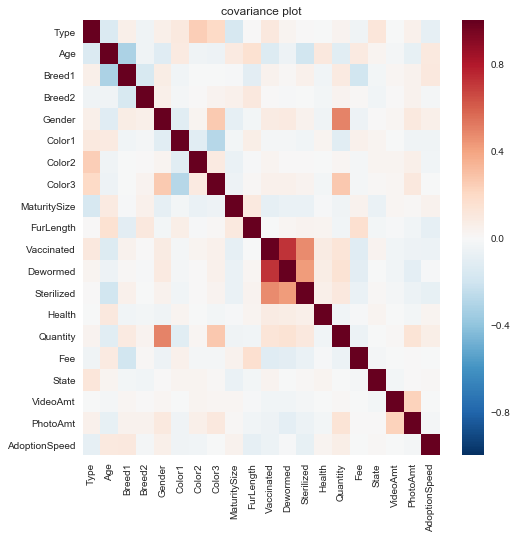

In [46]:
import seaborn as sns

fig = plt.figure(figsize=(8,8))
sns.heatmap(train_corr)
plt.title('covariance plot')
fig.savefig('../images/heatmap.png', bbox_inches='tight')

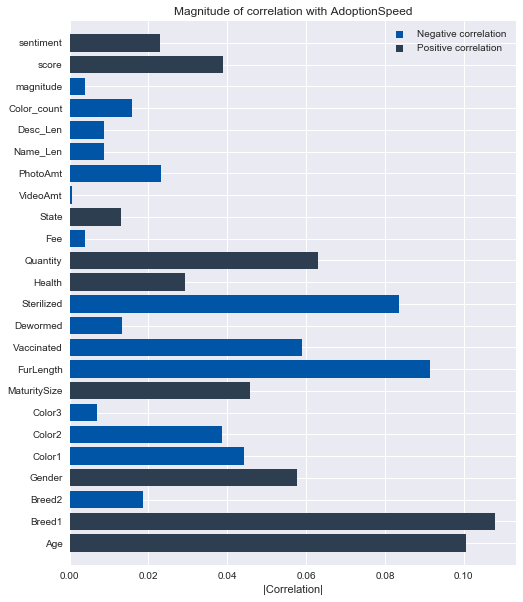

In [47]:
bar_colors = ['#0055A7' if x else '#2C3E4F' for x in list(dfNum_corr.values < 0)]
color_labels = {'#0055A7':'Negative correlation', '#2C3E4F':'Positive correlation'}

conditional_bar(dfNum_corr.apply(np.abs), bar_colors, color_labels,
               title='Magnitude of correlation with AdoptionSpeed',
               xlabel='|Correlation|')

In [48]:
corr_num_cols = ['sentiment', 'score', 'Color_count', 'Desc_Len', 'Name_Len', 'PhotoAmt', 'Quantity', 'MaturitySize', 'Age']
corr_cat_cols = ['Health','Sterilized','Dewormed', 'Vaccinated', 'FurLength', 'Color1', 'Color2', 'Color3','Gender',
                 'Breed2', 'Breed1']

In [49]:
# Plot histogram for categorical features i.e. Breed, Color, State

# Name Frequency and Adoptability

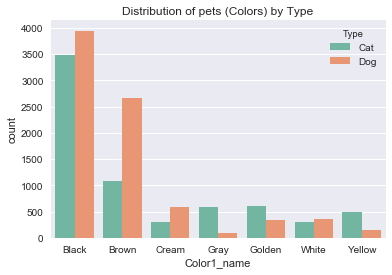

In [50]:
sns.countplot(x="Color1_name", hue="Type", data=dfAll, palette='Set2')
plt.title('Distribution of pets (Colors) by Type')
plt.show()

In [51]:
dfAll['Color_count'][:10]

0    2
1    2
2    2
3    2
4    1
5    2
6    1
7    3
8    1
9    2
Name: Color_count, dtype: int64

In [52]:
dfAll.Type.value_counts()

Dog    8132
Cat    6861
Name: Type, dtype: int64

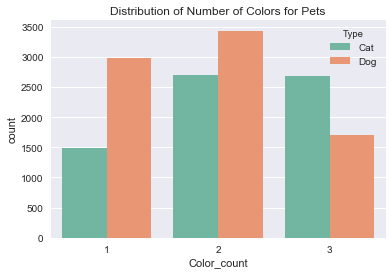

In [53]:
sns.countplot(x="Color_count", hue="Type", data=dfAll, palette='Set2')
plt.title('Distribution of Number of Colors for Pets')
plt.show()

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


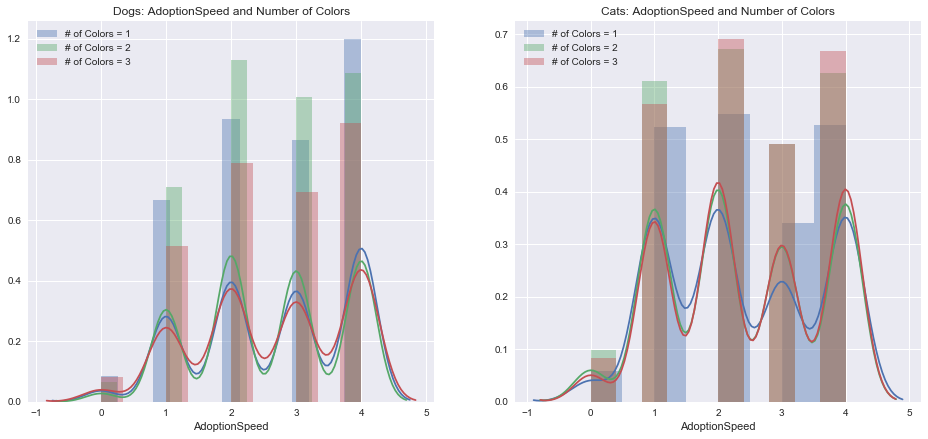

In [148]:
fig = plt.figure(figsize=(16,7))
plt.subplot(1,2,1)

plt.title('Dogs: AdoptionSpeed and Number of Colors')
for color in range(1,4):
    sns.distplot(dfAll[(dfAll.Type=='Dog')&(dfAll.Color_count == color)]
                 ['AdoptionSpeed'].dropna(), hist=True, rug=False, label="# of Colors = {}".format(color))

plt.legend()
plt.subplot(1,2,2)    
plt.title('Cats: AdoptionSpeed and Number of Colors')
for color in range(1,4):
    sns.distplot(dfAll[(dfAll.Type=='Cat')&(dfAll.Color_count == color)]
                 ['AdoptionSpeed'].dropna(), hist=True, rug=False, label="# of Colors = {}".format(color))
plt.legend()
fig.savefig('../images/numcolors.png', bbox_inches='tight')


In [55]:
dogs = dfAll[dfAll.Type=='Dog']
cats = dfAll[dfAll.Type=='Cat']

health = ['1_1_1_1', '1_2_1_1', '1_1_2_1', '1_2_2_1', '2_2_2_1', '3_3_3_1']

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


error


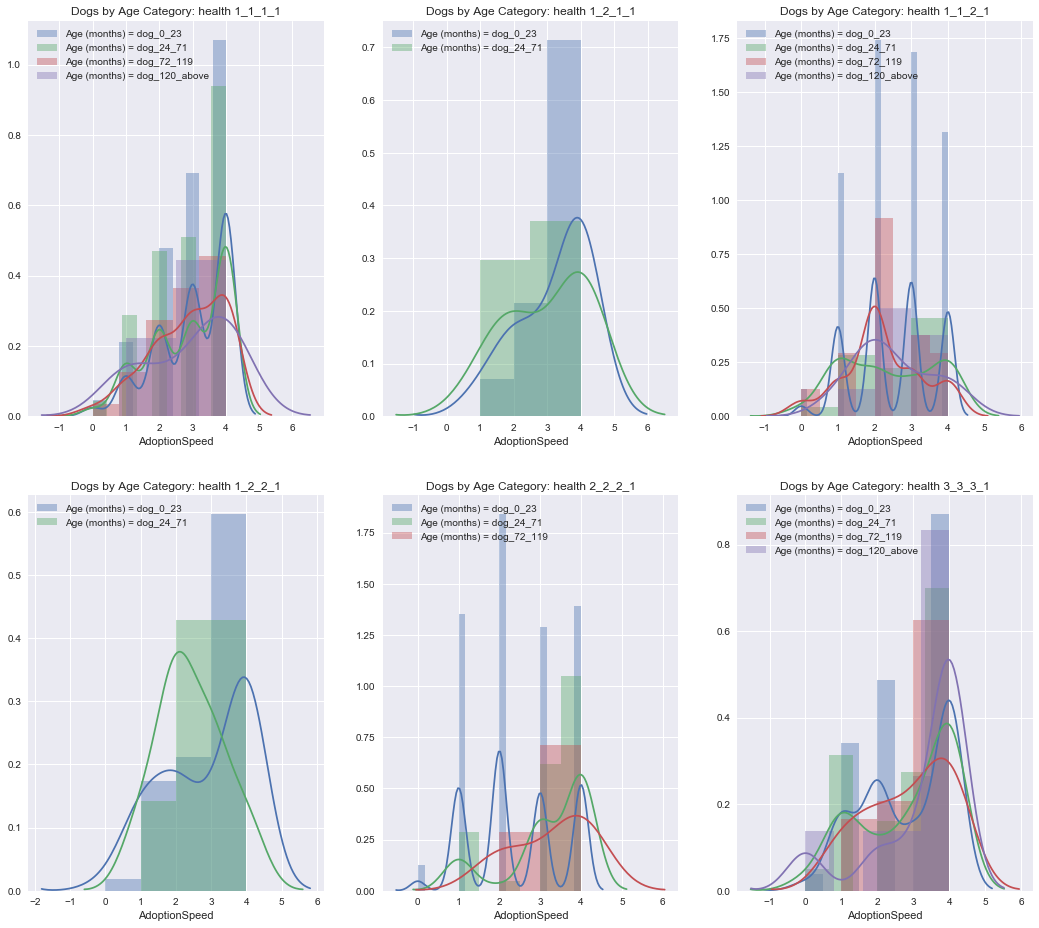

In [146]:
fig = plt.figure(figsize=(18,16))
cat_age = ['cat_0_1', 'cat_2_5','cat_6_11', 'cat_12_above']
dog_age = ['dog_0_23','dog_24_71', 'dog_72_119','dog_120_above']

for i, label in enumerate(health):
    plt.subplot(2,3,i+1)
    
    for age in dog_age:
        count = dogs[(dogs.age_cat == age)& (dogs.health == label)]['health'].count()
        #print(label, age, count)
        if count > 0:
            try: 
                sns.distplot(dogs[(dogs.age_cat == age)&(dogs.health==label)]
                     ['AdoptionSpeed'].dropna(), hist=True, rug=False, label="Age (months) = {}".format(age))
            except:
                print('error')
    
    plt.title('Dogs by Age Category: health {}'.format(label))
    plt.legend(loc=2)    


fig.savefig('../images/Doghealth_x_Age.png', bbox_inches='tight')

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


error


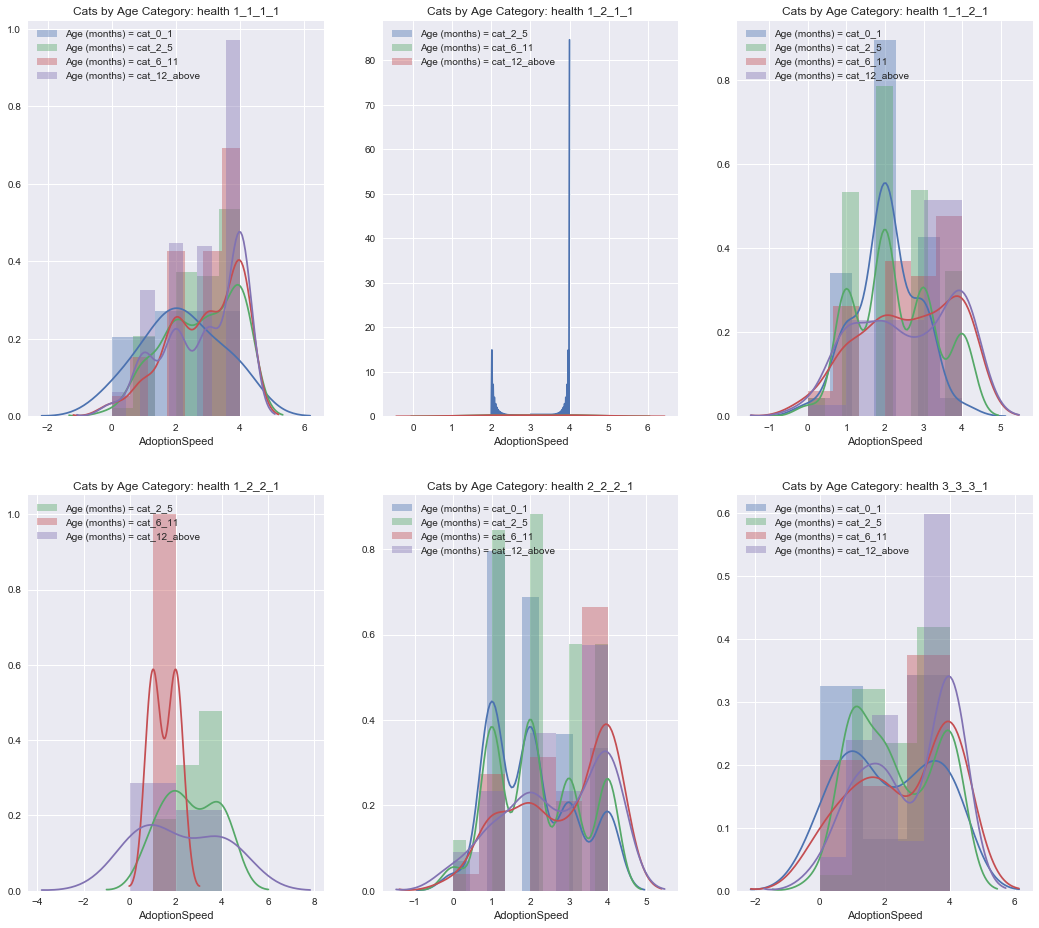

In [147]:
fig = plt.figure(figsize=(18,16))
cat_age = ['cat_0_1', 'cat_2_5','cat_6_11', 'cat_12_above']

for i, label in enumerate(health):
    plt.subplot(2,3,i+1)
    
    for age in cat_age:
        count = cats[(cats.age_cat == age)& (cats.health == label)]['health'].count()
        #print(label, age, count)
        if count > 0:
            try: 
                sns.distplot(cats[(cats.age_cat == age)&(cats.health==label)]
                     ['AdoptionSpeed'].dropna(), hist=True, rug=False, label="Age (months) = {}".format(age))
            except:
                print('error')
    
    plt.title('Cats by Age Category: health {}'.format(label))
    plt.legend(loc=2)    


fig.savefig('../images/Catshealth_x_Age.png', bbox_inches='tight')

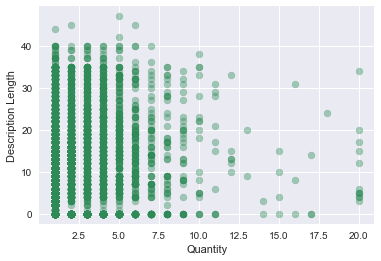

In [59]:
plt.scatter(dfAll['Quantity'], dfAll['Name_Len'], color='seagreen', alpha=0.4, label='Group 0')
plt.xlabel('Quantity')
plt.ylabel('Description Length')
plt.show()

In [60]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [61]:
breed[breed.BreedID.isin([307,76])]

,BreedID,Type,BreedName
75,76,1,Dalmatian
240,307,1,Mixed Breed


In [62]:
train[train['PetID']=='0a0e8c15b'].T

,5290
Type,1
Name,Fenny
Age,5
Breed1,307
Breed2,76
Gender,2
Color1,1
Color2,6
Color3,7
MaturitySize,2


In [63]:
train['Description'][0]

"Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care."

In [64]:
dfAll.head().T

,0,1,2,3,4
Type,Cat,Cat,Dog,Dog,Dog
Name,Nibble,No Name Yet,Brisco,Miko,Hunter
Age,3,1,1,4,1
Breed1,299,265,307,307,307
Breed2,0,0,0,0,0
Gender,1,1,1,2,1
Color1,1,1,2,1,1
Color2,7,2,7,2,0
Color3,0,0,0,0,0
MaturitySize,1,2,2,2,2


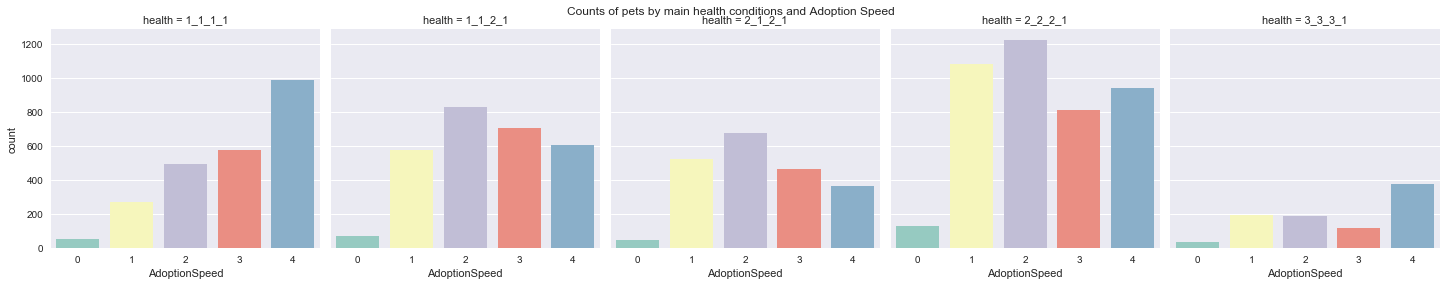

In [65]:
sns.factorplot('AdoptionSpeed', col='health', palette='Set3', data=dfAll.loc[dfAll['health'].isin(list(dfAll.health.value_counts().index[:5]))], kind='count');
plt.subplots_adjust(top=0.9)
plt.suptitle('Counts of pets by main health conditions and Adoption Speed');
plt.savefig('../images/health.png', bbox_inches='tight')

In [66]:
dfAll.groupby(['Vaccinated','Dewormed','Sterilized','Health','age_cat','Type'])['Name'].count()

Vaccinated  Dewormed  Sterilized  Health  age_cat        Type
1           1         1           1       cat_0_1        Cat       11
                                          cat_12_above   Cat      537
                                          cat_2_5        Cat      137
                                          cat_6_11       Cat      230
                                          dog_0_23       Dog      815
                                          dog_120_above  Dog       12
                                          dog_24_71      Dog      525
                                          dog_72_119     Dog      110
                                  2       cat_12_above   Cat        8
                                          cat_2_5        Cat        2
                                          cat_6_11       Cat        5
                                          dog_0_23       Dog       11
                                          dog_24_71      Dog       26
                            

DataFrame Columns

In [67]:
corr_num_cols = ['sentiment', 'score', 'Color_count', 'Desc_Len', 'Name_Len', 'PhotoAmt', 'Quantity', 'MaturitySize', 'Age']
corr_cat_cols = ['Health','Sterilized','Dewormed', 'Vaccinated', 'FurLength', 'Color1', 'Color2', 'Color3','Gender',
                 'Breed2', 'Breed1']

In [68]:
cat_cols = ['Type', 'State', 'Breed_Ind', 'Color1_name', 'Color2_name', 'Color3_name', 'Breed1_name', 'Breed2_name','health']
num_cols = ['Age', 'Fee', 'PhotoAmt', 'Desc_Len', 'Color_count']

In [69]:
dfAll.State.value_counts()

41326    8714
41401    3845
41327     843
41336     507
41330     420
41332     253
41324     137
41325     110
41335      85
41361      26
41345      22
41367      15
41342      13
41415       3
Name: State, dtype: int64

In [70]:
print(F'Maximum amount of photos in {dfAll["PhotoAmt"].max()}')
train['PhotoAmt'].value_counts().head()

Maximum amount of photos in 30.0


1.0    3075
2.0    2518
3.0    2511
5.0    2147
4.0    1881
Name: PhotoAmt, dtype: int64

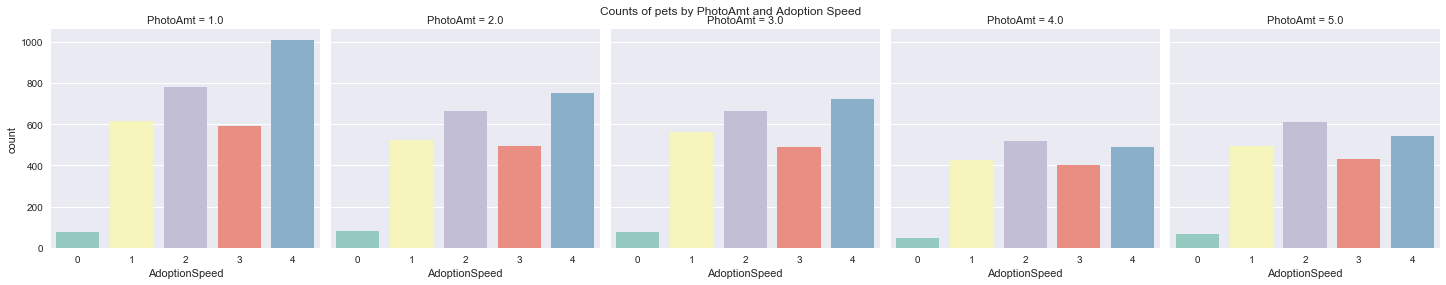

In [71]:
sns.factorplot('AdoptionSpeed', col='PhotoAmt', palette='Set3', data=dfAll.loc[dfAll['PhotoAmt'].isin(list(dfAll.PhotoAmt.value_counts().index[:5]))], kind='count');
plt.subplots_adjust(top=0.9)
plt.suptitle('Counts of pets by PhotoAmt and Adoption Speed');
plt.savefig('../images/PhotoAmt.png', bbox_inches='tight')

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


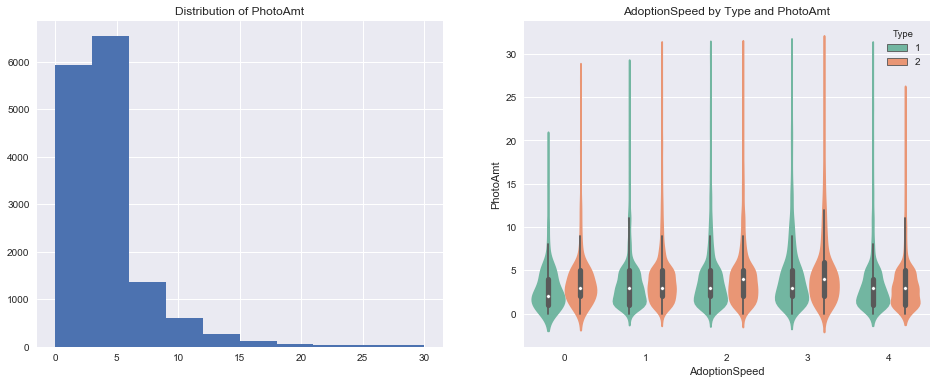

In [72]:
plt.figure(figsize=(16, 6));
plt.subplot(1, 2, 1)
plt.hist(dfAll['PhotoAmt']);
plt.title('Distribution of PhotoAmt');

plt.subplot(1, 2, 2)
sns.violinplot(x="AdoptionSpeed", y="PhotoAmt", hue="Type", palette='Set2', data=train);
plt.title('AdoptionSpeed by Type and PhotoAmt');

In [73]:
dfAll[dfAll.score == 0].groupby(['Type','AdoptionSpeed'])['Name'].count()

Type  AdoptionSpeed
Cat   0                 58
      1                344
      2                354
      3                246
      4                373
Dog   0                 29
      1                300
      2                428
      3                392
      4                355
Name: Name, dtype: int64